In [33]:
#All of this code is pulled from: https://scipy-cookbook.readthedocs.io/items/LoktaVolterraTutorial.html
import numpy as np
import matplotlib.pyplot as plt
import copy
from numpy import *
import pylab as p

In [34]:
# Definition of parameters 
a = 1.
b = 0.1
c = 1.5
d = 0.75


In [35]:

def dX_dt(X, t=0):
    """ Return the growth rate of fox and rabbit populations. """
    return array([ a*X[0] -   b*X[0]*X[1] ,  
                  -c*X[1] + d*b*X[0]*X[1] ])


In [36]:
# === Population equilibrium ===
# 
# Before using !SciPy to integrate this system, we will have a closer look on 
# position equilibrium. Equilibrium occurs when the growth rate is equal to 0.
# This gives two fixed points:
# 
X_f0 = array([     0. ,  0.])
X_f1 = array([ c/(d*b), a/b])
all(dX_dt(X_f0) == zeros(2) ) and all(dX_dt(X_f1) == zeros(2)) # => True 
# 

True

In [37]:
# === Stability of the fixed points ===
# Near theses two points, the system can be linearized:
# dX_dt = A_f*X where A is the Jacobian matrix evaluated at the corresponding point.
# We have to define the Jacobian matrix:
# 
def d2X_dt2(X, t=0):
    """ Return the Jacobian matrix evaluated in X. """
    return array([[a -b*X[1],   -b*X[0]     ],
                  [b*d*X[1] ,   -c +b*d*X[0]] ])  
# 

In [38]:

# So, near X_f0, which represents the extinction of both species, we have:
# A_f0 = d2X_dt2(X_f0)                    # >>> array([[ 1. , -0. ],
#                                         #            [ 0. , -1.5]])
# 
# Near X_f0, the number of rabbits increase and the population of foxes decrease.
# The origin is a [http://en.wikipedia.org/wiki/Saddle_point saddle point].
# 
# Near X_f1, we have:
A_f1 = d2X_dt2(X_f1)                    # >>> array([[ 0.  , -2.  ],
                                        #            [ 0.75,  0.  ]])

# whose eigenvalues are +/- sqrt(c*a).j:
lambda1, lambda2 = linalg.eigvals(A_f1) # >>> (1.22474j, -1.22474j)

# They are imaginary number, so the fox and rabbit populations are periodic and
# their period is given by:
T_f1 = 2*pi/abs(lambda1)                # >>> 5.130199
#         
# == Integrating the ODE using scipy.integate ==
# 
# Now we will use the scipy.integrate module to integrate the ODEs.
# This module offers a method named odeint, very easy to use to integrate ODEs:
# 
from scipy import integrate

t = linspace(0, 15,  1000)              # time
X0 = array([10, 5])                     # initials conditions: 10 rabbits and 5 foxes  
X, infodict = integrate.odeint(dX_dt, X0, t, full_output=True)
infodict['message']                     # >>> 'Integration successful.'

'Integration successful.'

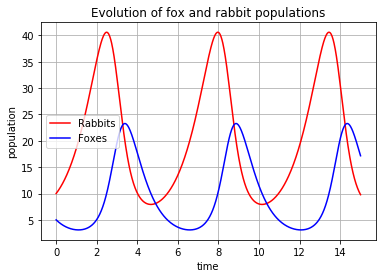

In [39]:

# 
# `infodict` is optional, and you can omit the `full_output` argument if you don't want it.
# Type "info(odeint)" if you want more information about odeint inputs and outputs.
# 
# We can now use Matplotlib to plot the evolution of both populations:
# 
rabbits, foxes = X.T

f1 = p.figure()
p.plot(t, rabbits, 'r-', label='Rabbits')
p.plot(t, foxes  , 'b-', label='Foxes')
p.grid()
p.legend(loc='best')
p.xlabel('time')
p.ylabel('population')
p.title('Evolution of fox and rabbit populations')
f1.savefig('rabbits_and_foxes_1.png')

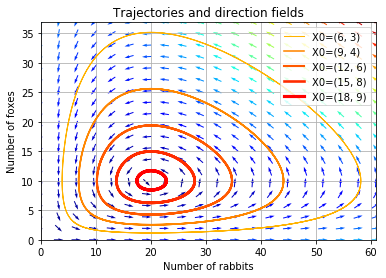

In [40]:

# 
# 
# The populations are indeed periodic, and their period is near to the T_f1 we calculated.
# 
# == Plotting direction fields and trajectories in the phase plane ==
# 
# We will plot some trajectories in a phase plane for different starting
# points between X__f0 and X_f1.
# 
# We will use matplotlib's colormap to define colors for the trajectories.
# These colormaps are very useful to make nice plots.
# Have a look at [http://www.scipy.org/Cookbook/Matplotlib/Show_colormaps ShowColormaps] if you want more information.
# 
values  = linspace(0.3, 0.9, 5)                          # position of X0 between X_f0 and X_f1
vcolors = p.cm.autumn_r(linspace(0.3, 1., len(values)))  # colors for each trajectory

f2 = p.figure()
#-------------------------------------------------------
# plot trajectories
for v, col in zip(values, vcolors): 
    X0 = v * X_f1                               # starting point
    X = integrate.odeint( dX_dt, X0, t)         # we don't need infodict here
    p.plot( X[:,0], X[:,1], lw=3.5*v, color=col, label='X0=(%.f, %.f)' % ( X0[0], X0[1]) )

#-------------------------------------------------------
# define a grid and compute direction at each point
ymax = p.ylim(ymin=0)[1]                        # get axis limits
xmax = p.xlim(xmin=0)[1] 
nb_points   = 20                      

x = linspace(0, xmax, nb_points)
y = linspace(0, ymax, nb_points)

X1 , Y1  = meshgrid(x, y)                       # create a grid
DX1, DY1 = dX_dt([X1, Y1])                      # compute growth rate on the gridt
M = (hypot(DX1, DY1))                           # Norm of the growth rate 
M[ M == 0] = 1.                                 # Avoid zero division errors 
DX1 /= M                                        # Normalize each arrows
DY1 /= M                                  

#-------------------------------------------------------
# Drow direction fields, using matplotlib 's quiver function
# I choose to plot normalized arrows and to use colors to give information on
# the growth speed
p.title('Trajectories and direction fields')
Q = p.quiver(X1, Y1, DX1, DY1, M, pivot='mid', cmap=p.cm.jet)
p.xlabel('Number of rabbits')
p.ylabel('Number of foxes')
p.legend()
p.grid()
p.xlim(0, xmax)
p.ylim(0, ymax)
f2.savefig('rabbits_and_foxes_2.png')


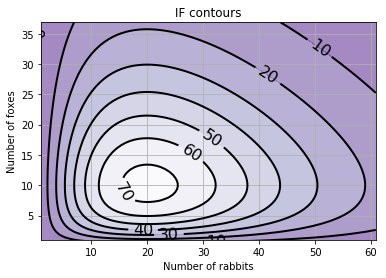

In [41]:








# 
# 
# We can see on this graph that an intervention on fox or rabbit populations can
# have non intuitive effects. If, in order to decrease the number of rabbits,
# we introduce foxes, this can lead to an increase of rabbits in the long run,
# if that intervention happens at a bad moment.
# 
# 
# == Plotting contours ==
# 
# We can verify that the function IF defined below remains constant along a trajectory:
# 
def IF(X):
    u, v = X
    return u**(c/a) * v * exp( -(b/a)*(d*u+v) )

# We will verify that IF remains constant for different trajectories
for v in values: 
    X0 = v * X_f1                               # starting point
    X = integrate.odeint( dX_dt, X0, t)         
    I = IF(X.T)                                 # compute IF along the trajectory
    I_mean = I.mean()
    delta = 100 * (I.max()-I.min())/I_mean
    #print 'X0=(%2.f,%2.f) => I ~ %.1f |delta = %.3G %%' % (X0[0], X0[1], I_mean, delta)

# >>> X0=( 6, 3) => I ~ 20.8 |delta = 6.19E-05 %
#     X0=( 9, 4) => I ~ 39.4 |delta = 2.67E-05 %
#     X0=(12, 6) => I ~ 55.7 |delta = 1.82E-05 %
#     X0=(15, 8) => I ~ 66.8 |delta = 1.12E-05 %
#     X0=(18, 9) => I ~ 72.4 |delta = 4.68E-06 %
# 
# Potting iso-contours of IF can be a good representation of trajectories,
# without having to integrate the ODE
# 
#-------------------------------------------------------
# plot iso contours
nb_points = 80                              # grid size 

x = linspace(0, xmax, nb_points)    
y = linspace(0, ymax, nb_points)

X2 , Y2  = meshgrid(x, y)                   # create the grid
Z2 = IF([X2, Y2])                           # compute IF on each point

f3 = p.figure()
CS = p.contourf(X2, Y2, Z2, cmap=p.cm.Purples_r, alpha=0.5)
CS2 = p.contour(X2, Y2, Z2, colors='black', linewidths=2. )
p.clabel(CS2, inline=1, fontsize=16, fmt='%.f')
p.grid()
p.xlabel('Number of rabbits')
p.ylabel('Number of foxes')
p.ylim(1, ymax)
p.xlim(1, xmax)
p.title('IF contours')
f3.savefig('rabbits_and_foxes_3.png')
p.show()
